In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = 'data/lenet_mnist_model.pth'
use_cuda = True

In [3]:
#Define the LeNet Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d((self.conv1(x)),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

In [4]:
#Data Loader for test set
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, 
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=1, shuffle = True)

In [5]:
print("CUDA Available: ", torch.cuda.is_available())

CUDA Available:  True


In [6]:
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu") 

In [7]:
#Load pre-trianed model
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
#Define the attack function
def fgsm_attack(image, epsilon, data_grad):
    
    #Get the sign of the gradient of loss with respect to the input
    sign_data_grad = data_grad.sign()
    
    #Perturb the image in the direction of positive gradient
    perturbed_image = image + epsilon*sign_data_grad
    
    #Clip the values of the perturbed image between 0 and 1
    torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [9]:
#Testing function

def test(model, device, test_loader, epsilon):
    original_correct = 0
    correct = 0
    adv_examples = []
    
    #Iterate through the test set one at a time
    for data, target in test_loader:
        
        #Move the data and target tensor to GPU
        data, target = data.to(device), target.to(device)
        
        #We need the gradient of loss with respect to the input. Set requires_grad to true
        data.requires_grad = True
        
        #Predict the outut for the test sample
        output = model(data)
        
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() == target.item():
            original_correct += 1
        
        #If the initial prediction is mismatched no point attacking it
        if init_pred.item() != target.item():
            continue
        
        #Calculate the loss
        loss = F.nll_loss(output, target)
        
        #Set al gradients to 0
        model.zero_grad()
        
        #Backprop (Also calculates gradient of loss wrt input since we set requires_grad to True)
        loss.backward()
        
        #Get the gradient of loss with respect to input
        data_grad = data.grad.data
        
        #Perturb the image using the gradient
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        #Predict the output for the perturbed image
        output = model(perturbed_data)
        perturbed_pred = output.max(1, keepdim = True)[1]
        
        #Calculate the accuracy of the model after the attack
        if perturbed_pred.item() == target.item():
            correct += 1
            if epsilon==0 and len(adv_examples)<5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), perturbed_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), perturbed_pred.item(), adv_ex))
                
    original_acc = original_correct/float(len(test_loader))
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\t Original Test Accuracy: {}/{} = {}\t Adversarial Test Accuracy = {}/{} = {}\n"
          .format(epsilon, original_correct, float(len(test_loader)), original_acc, correct, float(len(test_loader)), 
                  final_acc))
        
    return original_acc, final_acc, adv_examples

In [10]:
original_accuracies, adverse_accuracies, examples = [], [], []

#Evaluate the extent of attack for different epsilon
for eps in epsilons:
    orig, acc, ex = test(model, device, test_loader, eps)
    original_accuracies.append(orig)
    adverse_accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 9810/10000.0 = 0.981

Epsilon: 0.05	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 9093/10000.0 = 0.9093

Epsilon: 0.1	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 7301/10000.0 = 0.7301

Epsilon: 0.15	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 4440/10000.0 = 0.444

Epsilon: 0.2	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 1981/10000.0 = 0.1981

Epsilon: 0.25	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 761/10000.0 = 0.0761

Epsilon: 0.3	 Original Test Accuracy: 9810/10000.0 = 0.981	 Adversarial Test Accuracy = 346/10000.0 = 0.0346



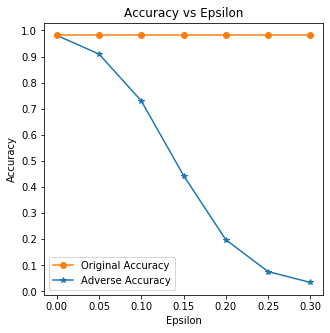

In [11]:
#Plot the accuracies of the model for different epsilon
plt.figure(figsize=(5,5))

adv_acc, = plt.plot(epsilons, adverse_accuracies, "*-", label = 'Adverse Accuracy')
orig_acc, = plt.plot(epsilons, original_accuracies, "o-", label = 'Original Accuracy')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 0.35, 0.05))

plt.title("Accuracy vs Epsilon")
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")

plt.legend(handles=[orig_acc, adv_acc])
plt.show()

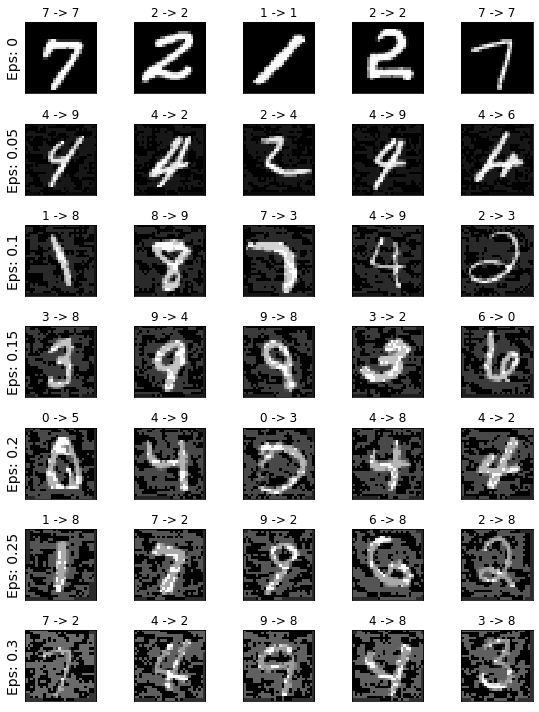

In [12]:
#Visualize some of the aversarial examples
count = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        plt.subplot(len(epsilons),len(examples[0]),count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()